Numbers for reference:

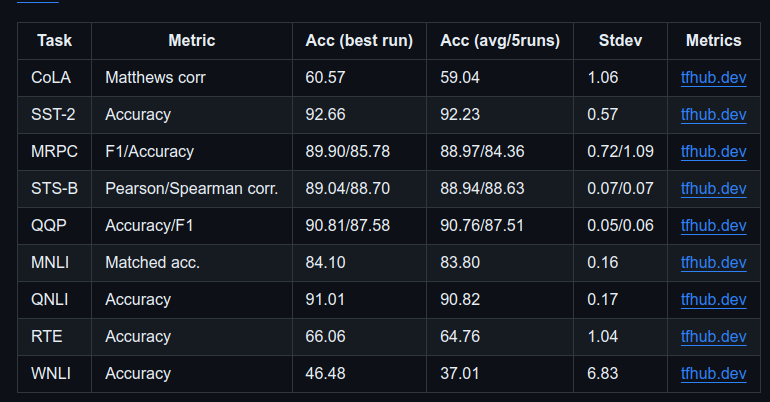

In [1]:
#! pip install datasets transformers

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [2]:
from huggingface_hub import notebook_login

# notebook_login()

Then you need to install Git-LFS. Uncomment the following instructions:

In [3]:
# !apt install git-lfs

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [4]:
import transformers

print(transformers.__version__)

4.27.0.dev0


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/text-classification).

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [5]:
# from transformers.utils import send_example_telemetry

# send_example_telemetry("text_classification_notebook", framework="pytorch")

# Fine-tuning a model on a text classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [GLUE Benchmark](https://gluebenchmark.com/).

![Widget inference on a text classification task](images/text_classification.png)

The GLUE Benchmark is a group of nine classification tasks on sentences or pairs of sentences which are:

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically correct or not.is a  dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This dataset is built from the Winograd Schema Challenge dataset.)

We will see how to easily load the dataset for each one of those tasks and use the `Trainer` API to fine-tune a model on it. Each task is named by its acronym, with `mnli-mm` standing for the mismatched version of MNLI (so same training set as `mnli` but different validation and test sets):

In [6]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

This notebook is built to run on any of the tasks in the list above, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a classification head. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [7]:
task = "cola"
model_checkpoint = "Bergman_Dec26_22-55-58_raven_310000/"
batch_size = 128

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [8]:
from datasets import load_dataset, load_metric

Apart from `mnli-mm` being a special code, we can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [9]:
actual_task = "mnli" if task == "mnli-mm" else task
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)

Found cached dataset glue (/home/eugene/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_31409/1389288479.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', actual_task)


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

To access an actual element, you need to select a split first, then give an index:

In [11]:
dataset["train"][0]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [12]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [13]:
show_random_elements(dataset["train"])

,sentence,label,idx
0,"The more people you give beer to, the more people that get sick.",acceptable,211
1,We believed him to be omnipotent,acceptable,8492
2,Who has seen my snorkel?,acceptable,6204
3,Barbara handed them to Alan on Tuesday.,acceptable,6651
4,John is prouder of having gone than Sally expected Joan to believe that the man who didn't shave would be.,acceptable,1546
5,The lions ate at the meat raw.,unacceptable,768
6,Leslie staffed the store with employees.,acceptable,2603
7,Amanda carried packages to New York.,acceptable,2696
8,The president who Fred voted for has resigned.,acceptable,4876
9,"He had hardly collected the papers on his desk, had he?",acceptable,4587


The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [14]:
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [15]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'matthews_correlation': -0.11834526708278773}

Note that `load_metric` has loaded the proper metric associated to your task, which is:

- for CoLA: [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)
- for MNLI (matched or mismatched): Accuracy
- for MRPC: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for QNLI: Accuracy
- for QQP: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for RTE: Accuracy
- for SST-2: Accuracy
- for STS-B: [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman's_Rank_Correlation_Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
- for WNLI: Accuracy

so the metric object only computes the one(s) needed for your task.

## Preprocessing the data

In [16]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("./bergman-tokenizer_32k/", max_len=512)

from tokenizers import normalizers
from tokenizers.normalizers import BertNormalizer
tokenizer.backend_tokenizer.normalizer = normalizers.Sequence([BertNormalizer()])

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [17]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [0, 16963, 16, 464, 506, 8386, 5, 2, 2, 295, 464, 8386, 4315, 353, 347, 18, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokenizer.decode(tokenizer("Hello, this one sentence!", "And this sentence goes with it.")['input_ids'])

'<s> hello, this one sentence!</s></s> and this sentence goes with it.</s>'

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [19]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

We can double check it does work on our current dataset:

In [20]:
sentence1_key, sentence2_key = task_to_keys[task]
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: Our friends won't buy this analysis, let alone the next one we propose.


We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [21]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [22]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[0, 1106, 2754, 1225, 528, 5605, 464, 4786, 16, 1204, 3187, 265, 1476, 506, 476, 22051, 18, 2], [0, 506, 672, 22506, 1373, 1823, 295, 356, 1194, 3808, 529, 18, 2], [0, 506, 672, 22506, 1373, 1823, 411, 356, 1194, 3808, 529, 18, 2], [0, 265, 672, 476, 2686, 22516, 16, 265, 4634, 22449, 484, 876, 18, 2], [0, 816, 378, 816, 265, 10832, 436, 3007, 2000, 79, 886, 18, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [23]:
tokenizer.decode(preprocess_function(dataset['train'][:5])['input_ids'][0])

"<s> our friends won't buy this analysis, let alone the next one we propose.</s>"

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [24]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at /home/eugene/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-8e303b2f0ab76b0d.arrow
Loading cached processed dataset at /home/eugene/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-283963e52733fb64.arrow
Loading cached processed dataset at /home/eugene/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-55ca39ff9e8425b5.arrow


In [25]:
max([len(t["input_ids"]) for t in encoded_dataset["train"]])

48

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

In [26]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [27]:
from bergman import BergmanForSequenceClassification

model = BergmanForSequenceClassification.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at Bergman_Dec26_22-55-58_raven_310000/ were not used when initializing BergmanForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing BergmanForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BergmanForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BergmanForSequenceClassification were not initialized from the model checkpoint at Bergman_Dec26_22-55-58_raven_310000/ and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj

In [30]:
 len(model.bergman.encoder.layer)

2

In [37]:
# # freeze backbone
for param in model.bergman.parameters():
    param.requires_grad = False
    
for param in model.bergman.encoder.layer[-1].parameters():
    param.requires_grad = True

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [38]:
model_checkpoint

'Bergman_Dec26_22-55-58_raven_310000/'

In [39]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = [s for s in model_checkpoint.split("/") if len(s) > 0][-1]
print("Model name:", model_name)

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=30,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Model name: Bergman_Dec26_22-55-58_raven_310000


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

In [40]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [41]:
validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BergmanForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BergmanForSequenceClassification.forward`,  you can safely ignore this message.
/home/eugene/Projects/matrix_network/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8551
  Num Epochs = 30
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 2010
  Number of trainable parameters = 10043138


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.584330,0.160276
2,No log,0.569967,0.224861
3,No log,0.561078,0.254193
4,No log,0.560155,0.261713
5,No log,0.549021,0.295843
6,No log,0.553625,0.308707
7,No log,0.551385,0.303642
8,0.513200,0.564543,0.290391
9,0.513200,0.576565,0.299728
10,0.513200,0.582808,0.323110


The following columns in the evaluation set don't have a corresponding argument in `BergmanForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BergmanForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 128
Saving model checkpoint to Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-67
Configuration saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-67/config.json
Model weights saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-67/pytorch_model.bin
tokenizer config file saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-67/tokenizer_config.json
Special tokens file saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-67/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BergmanForSequenceClassifica

***** Running Evaluation *****
  Num examples = 1043
  Batch size = 128
Saving model checkpoint to Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-670
Configuration saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-670/config.json
Model weights saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-670/pytorch_model.bin
tokenizer config file saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-670/tokenizer_config.json
Special tokens file saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-670/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BergmanForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BergmanForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 128
Saving model checkpoint to Bergman_

Configuration saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-1273/config.json
Model weights saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-1273/pytorch_model.bin
tokenizer config file saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-1273/tokenizer_config.json
Special tokens file saved in Bergman_Dec26_22-55-58_raven_310000-finetuned-cola/checkpoint-1273/special_tokens_map.json


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate()

To see how your model fared you can compare it to the [GLUE Benchmark leaderboard](https://gluebenchmark.com/leaderboard).

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
# trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("sgugger/my-awesome-model")
```

In [ ]:
raise Exception()

## Hyperparameter search

The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [ ]:
# ! pip install optuna
# ! pip install ray[tune]

During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

And we can instantiate our `Trainer` like before:

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [ ]:
best_run

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()